In [1]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
%matplotlib inline

C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Delbert\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

# Data Reading and Preprocessing

In [2]:
# Read in text, create inclusion and exclusion columns, and clean
df = pd.read_csv("data_tier-1_sample.csv")
df["cohort"] = df["cohort"].apply(json.loads) 

df["inclusion"] = ["None"]*len(df)
df["exclusion"] = ["None"]*len(df)

cohort = df["cohort"]
for x in range(len(cohort)):
    df["inclusion"][x] = cohort[x]["inclusion"]
    df["exclusion"][x] = cohort[x]["exclusion"]
    

def clean_text(x):
    x = re.sub("-", "", x)
    x = re.sub("\(", " ", x)
    x = re.sub("\)", " ", x)
    return x
    
df["query"] = df["query"].apply(clean_text)
    
df.head(5)

,query,cohort,inclusion,exclusion
0,show me patients with hyperplasia of maxillary...,{'inclusion': ['hyperplasia of maxillary bone'...,[hyperplasia of maxillary bone],"[anemia due to chronic blood loss, transjugula..."
1,should people with ventricular septal defect a...,"{'inclusion': ['ventricular septal defect', 'a...","[ventricular septal defect, abnormal findings ...","[headache following lumbar puncture, age<=75, ..."
2,can you show me the recovery rate for patients...,"{'inclusion': ['age<68', 'comedonal acne', 'n-...","[age<68, comedonal acne, n-(1-benzyl-3,3,3-tri...","[hypoplasia of the optic nerve, 3-oxo-octanoic..."
3,genetic predispositions to oropharyngeal aspirate,"{'inclusion': ['oropharyngeal aspirate'], 'exc...",[oropharyngeal aspirate],[]
4,can you show me the recovery rate for patients...,"{'inclusion': ['age>=7', 'sensory hearing loss...","[age>=7, sensory hearing loss]","[quadriparesis, 5-(2,5-dichlorophenyl)-2-furoi..."


In [3]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased',do_lower_case=True)

# Creating labels for each token based on exclusion and inclusion criteria
final_labels = []

for index, row in df.iterrows():
    
    tokenized_query = tokenizer.tokenize(row["query"])
    labels = ["Neither"]*len(tokenized_query)
    tokenized_inclusion = [tokenizer.tokenize(x) for x in row["inclusion"]]
    tokenized_exclusion = [tokenizer.tokenize(x) for x in row["exclusion"]]
    
    for criteria in tokenized_inclusion:
        for token in range(int(len(tokenized_query)-len(criteria))+1):
            if tokenized_query[token:token+len(criteria)] == criteria:
                labels[token:token+len(criteria)] = ["include"] * len(criteria)
                
    for criteria in tokenized_exclusion:
        for token in range(int(len(tokenized_query)-len(criteria))+1):
            if tokenized_query[token:token+len(criteria)] == criteria:
                labels[token:token+len(criteria)] = ["exclude"] * len(criteria)
    
    final_labels.append(labels)

df["labels"] = final_labels

In [25]:
df.to_csv("final.csv", index = False)

# BERT Model 

### BERT Set-up

In [29]:
import torch
from torch import nn

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [42]:
# Creating conversion dictionary
tag_values = list(set(df["labels"].values[0]))
tag_values.append("PAD")
tag2idx = {t:i for i, t in enumerate(tag_values)}

In [31]:
# Parameters
device = torch.device("cuda")
MAX_LEN = max([len(x) for x in df["labels"]])
bs = 32

In [34]:
# Creating input data
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(query) for query in df["query"]]
labels = list(df["labels"])

In [32]:
# Padding inputs and converting tokens to ids
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

# Padding tags and converting to ids
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

# Creating masks
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [47]:
# Training and validation split
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=42, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.1)

In [48]:
# Converting all to tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [49]:
# Dataloader creation
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

### BERT fine-tuning

In [68]:
import transformers
from transformers import BertForTokenClassification, AdamW

from tqdm import tqdm, trange

In [69]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [70]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [71]:
# Setting parameters for fine-tuning
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [72]:
from transformers import get_linear_schedule_with_warmup

epochs = 6
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [73]:
from seqeval.metrics import f1_score, accuracy_score

In [74]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    
    #               Training

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    
    #               Validation

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Average train loss: 0.360353429583793


Epoch:  17%|█▋        | 1/6 [00:20<01:42, 20.44s/it]

Validation loss: 0.08084728692968686
Validation Accuracy: 0.971012402653591
Validation F1-Score: 0.8931583880037488

Average train loss: 0.0409306660888994


Epoch:  33%|███▎      | 2/6 [00:40<01:21, 20.43s/it]

Validation loss: 0.016542847113062937
Validation Accuracy: 0.9955292760311508
Validation F1-Score: 0.9862204724409449

Average train loss: 0.012561018754569615


Epoch:  50%|█████     | 3/6 [01:01<01:01, 20.39s/it]

Validation loss: 0.0031088751032560444
Validation Accuracy: 0.9985578309777906
Validation F1-Score: 0.9901768172888016

Average train loss: 0.004250277268472425


Epoch:  67%|██████▋   | 4/6 [01:21<00:40, 20.36s/it]

Validation loss: 0.0008751100491887579
Validation Accuracy: 0.9997115661955581
Validation F1-Score: 0.9980372914622179

Average train loss: 0.0017867243137864514


Epoch:  83%|████████▎ | 5/6 [01:41<00:20, 20.33s/it]

Validation loss: 0.0013775694023934193
Validation Accuracy: 0.9992789154888952
Validation F1-Score: 0.9980372914622179

Average train loss: 0.0015441474097315222


Epoch: 100%|██████████| 6/6 [02:01<00:00, 20.32s/it]

Validation loss: 0.001972499696421437
Validation Accuracy: 0.9992789154888952
Validation F1-Score: 0.9980372914622179



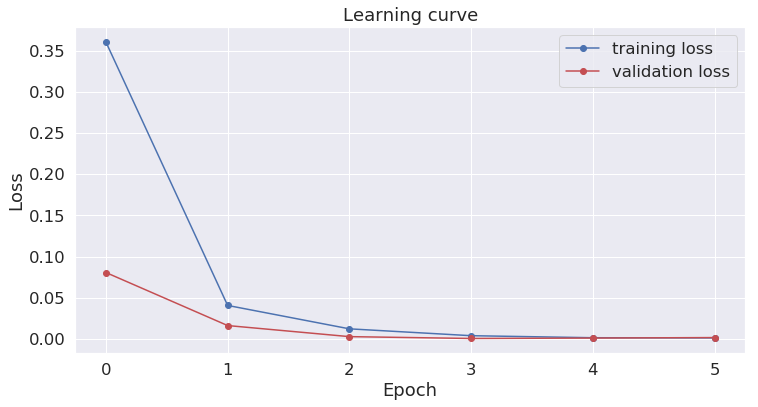

In [76]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [79]:
sample = "undergoing routine antenatal care but don't have adverse effect, caused by correct medicinal substance properly administered"

tokenized_sentence = tokenizer.encode(sample)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

Neither	[CLS]
Neither	undergoing
include	routine
include	antenatal
include	care
Neither	but
Neither	don
Neither	'
Neither	t
Neither	have
exclude	adverse
exclude	effect
Neither	,
exclude	caused
exclude	by
exclude	correct
exclude	medicinal
exclude	substance
Neither	properly
Neither	administered
include	[SEP]
